# Sign language digits recognition with Keras

<br>
1) [A look at the data](#Data)
<br>
2) [Trying a simple CNN with Keras](#Baseline)
<br>
3) [Improvements](#Improvements)

## Importing the libraries

In [3]:
# Libraries to manage the dataset
import os
from shutil import copyfile
import glob

# Deep leearnig and machine learning libraries (Keras and scikit learn)
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


# Classic libraries with python
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<a id="Data"></a>
## A look at the data

Label : 0


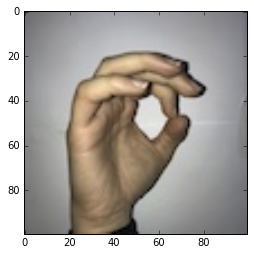

Label : 1


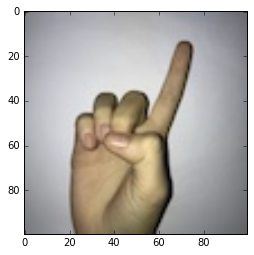

Label : 2


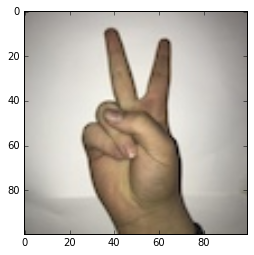

Label : 3


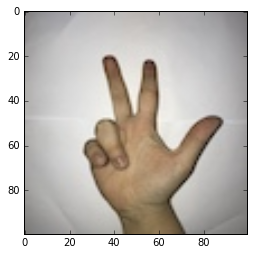

Label : 4


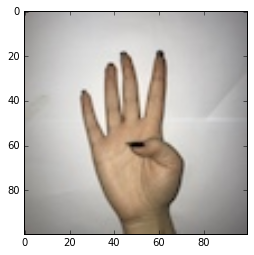

Label : 5


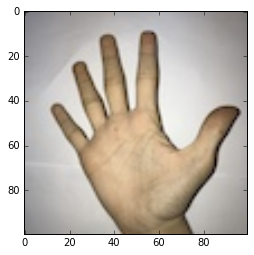

Label : 6


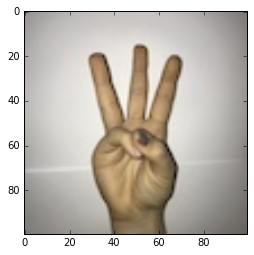

Label : 7


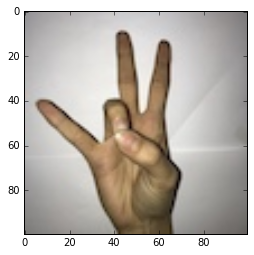

Label : 8


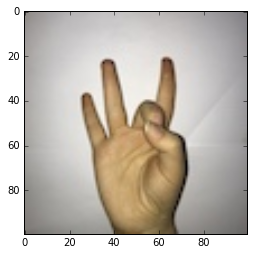

Label : 9


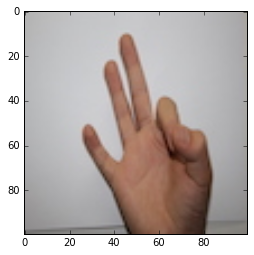

In [49]:
# The dataset is from github.com/ardamavi/Sign-language-Digits-Dataset

# The main folder is Dataset
dataset_path = "Dataset/"

# And each sub folders are digits from 0 to 9
labels = os.listdir(dataset_path) 

# Let's see one example for each digit 
for i in np.sort(labels) : 
    
    print("Label : %s"%i)
    
    # Reading the image with opencv (the format is BGR)
    image_name = dataset_path + i + "/" + (os.listdir(dataset_path + i + "/")[0])
    # ::-1 reverse the order of the channel thus convert the image to RGB
    image = cv2.imread(image_name)[:,:,::-1] 
    
    # We plot the image 
    plt.imshow(image) 
    plt.show()

# Use Keras data generator to get the data

<br>
Keras is actually very convenient when it's about using flow_from_directory with generators. However
we must prepare the data so that it's easy for this method to flow from directory.

<br>

So we will create a folder "data" with two subfolders "train" and "val" and digits for each. And obviously we need
to shuffle the dataset an then split it using the train_test_split function from sklearn.
<br>

So at the end of the cell below, we should have : 

data :
>    train : (90 %)
>>        0
>>        1
>>        2
>>        3
>>        4
>>        5
>>        6
>>        7
>>        8
>>        9

<br>

>    val :  (10 %)
>>        0
>>        1
>>        2
>>        3
>>        4
>>        5
>>        6
>>        7
>>        8
>>        9

In [10]:
# Checking if data has not been created yet
if (not os.path.exists("data")) : 

    # The first step to get all the data (not the images, only the names) 
    data_input = []
    data_output = []
    labels = os.listdir(dataset_path)

    for i in labels : 
        for j in glob.glob("Dataset/" + i + "/*.JPG") :
            
            data_input.append(j)
            data_output.append(i)        

    
    # Then using train_test_split, we get train and val dataset
    train_input, val_input, train_output, val_output = train_test_split(data_input, 
                                                                        data_output,
                                                                        train_size = 0.9,
                                                                        random_state = 42)

    # Finally we create the subfolders
    nb_image = len(data_output)
    nb_image_val = len(val_output)

    os.mkdir("data")
    os.mkdir("data/train")
    os.mkdir("data/val")

    for i in labels :
        os.mkdir("data/train/" + i)
        os.mkdir("data/val/" + i)

        
    # And copy all the images in the train and validation sets to the corresponding folders
    for i in train_input : 
        copyfile(i, "data/train/" + i.split("Dataset/")[1])

    for i in val_input : 
        copyfile(i, "data/val/" + i.split("Dataset/")[1])

In [17]:
# We simply use the ImageDataGenerator class from Keras resizing the input images
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Then both train and validation generator are made using the newly created directories
train_generator = train_datagen.flow_from_directory("data/train/",
                                                    target_size=(100,100),
                                                    batch_size = 32,
                                                    color_mode = 'grayscale',
                                                    class_mode = 'categorical')

validation_generator = train_datagen.flow_from_directory("data/val",
                                                         target_size=(100,100),
                                                         batch_size = 32,
                                                         color_mode = 'grayscale',
                                                         class_mode = 'categorical')

# Useful variables for after
n_train_images = train_generator.n
n_val_images = validation_generator.n

Found 1855 images belonging to 10 classes.
Found 207 images belonging to 10 classes.


<a id='Baseline'></a>
    
## Trying a simple CNN with Keras
    
The model is actually quite simple, a classic CNN with conv layers and max pooling layers to finally end with a
10 neurons layer, with a softmax activation as it should predict only one digit at a time.
<br>

One thing to note is that input image is a gray scale image so the input shoud be (100,100,1)

In [18]:
# Using Keras' Sequential model
model = models.Sequential()
model.add(layers.Conv2D(6,(3,3), activation='relu', input_shape=(100,100,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(12,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(24,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(36,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))


# The categorical crossentropy is used since it's a multilabel classification problem
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['acc'])


# Print out the model's summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 98, 98, 6)         60        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 49, 6)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 47, 12)        660       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 12)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 24)        2616      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 24)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 36)          7812      
__________

In [19]:
# Number of steps per epoch for the train and the validation pass
nb_steps_per_epoch = int(n_train_images/32)
validation_steps = int(n_val_images/32)

# The number of epochs is set to 40
epochs = 40

# Main learning loop
history = model.fit_generator(train_generator,
                              steps_per_epoch = nb_steps_per_epoch,
                              epochs = epochs,
                              validation_data = validation_generator,
                              validation_steps = validation_steps)

Epoch 1/40
57/57 [==============================] - 5s 91ms/step - loss: 2.3001 - acc: 0.1125 - val_loss: 2.2717 - val_acc: 0.2448
Epoch 2/40
57/57 [==============================] - 4s 78ms/step - loss: 1.7190 - acc: 0.4065 - val_loss: 0.8588 - val_acc: 0.7371
Epoch 3/40
57/57 [==============================] - 4s 78ms/step - loss: 0.7862 - acc: 0.7378 - val_loss: 0.4992 - val_acc: 0.8400
Epoch 4/40
57/57 [==============================] - 4s 78ms/step - loss: 0.5737 - acc: 0.8119 - val_loss: 0.3093 - val_acc: 0.9257
Epoch 5/40
57/57 [==============================] - 4s 77ms/step - loss: 0.4392 - acc: 0.8574 - val_loss: 0.3576 - val_acc: 0.8686
Epoch 6/40
57/57 [==============================] - 4s 72ms/step - loss: 0.3909 - acc: 0.8711 - val_loss: 0.2887 - val_acc: 0.9143
Epoch 7/40
57/57 [==============================] - 4s 77ms/step - loss: 0.3041 - acc: 0.9095 - val_loss: 0.2555 - val_acc: 0.9200
Epoch 8/40
57/57 [==============================] - 4s 71ms/step - loss: 0.2731 - a

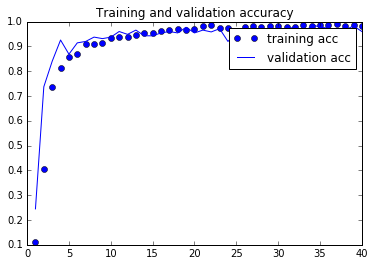

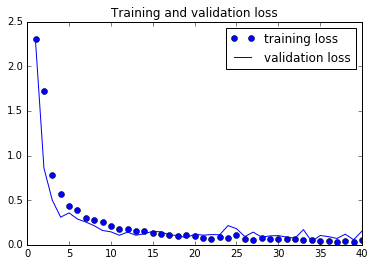

Maximum train accuracy : 0.9890
Maximum val accuracy : 0.9886


In [20]:
# This part of the code is from the awesome book :
# "Deep Learning with Python" from François Choolet
def plot_results(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label = 'training acc')
    plt.plot(epochs, val_acc, 'b', label = 'validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label = 'training loss')
    plt.plot(epochs, val_loss, 'b', label = 'validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
    
# So we plot the evolution of the training to see the baseline and how we can improve it
plot_results(history)

print("Maximum train accuracy : %.4f" %max(history.history["acc"]))
print("Maximum val accuracy : %.4f" %max(history.history["val_acc"]))

<a id='Improvements'></a>

## 3) Improvements

In [21]:
# We can use a deeper model (increase the capacity) to actually see the model overfitting the data
deeper_model = models.Sequential()
deeper_model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(100,100,1)))
deeper_model.add(layers.MaxPooling2D((2,2)))
deeper_model.add(layers.Conv2D(64,(3,3), activation='relu'))
deeper_model.add(layers.MaxPooling2D((2,2)))
deeper_model.add(layers.Conv2D(128,(3,3), activation='relu'))
deeper_model.add(layers.MaxPooling2D((2,2)))
deeper_model.add(layers.Conv2D(256,(3,3), activation='relu'))
deeper_model.add(layers.MaxPooling2D((2,2)))
deeper_model.add(layers.Flatten())
deeper_model.add(layers.Dense(512, activation='relu'))
deeper_model.add(layers.Dense(64, activation='relu'))
deeper_model.add(layers.Dense(32, activation='relu'))
deeper_model.add(layers.Dense(10, activation='softmax'))

# Same here
deeper_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['acc'])

# Printing the summary we clearly see the increase in the number of parameters
# From 86 294 to 2 520 746
deeper_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 256)         295168    
__________

In [22]:
# Number of steps per epoch for the train and the validation pass
nb_steps_per_epoch = int(n_train_images/32)
validation_steps = int(n_val_images/32)

# The number of epochs is still 40
epochs = 40

# Main learning loop
history = deeper_model.fit_generator(train_generator,
                              steps_per_epoch = nb_steps_per_epoch,
                              epochs = epochs,
                              validation_data = validation_generator,
                              validation_steps = validation_steps)

Epoch 1/40
57/57 [==============================] - 5s 84ms/step - loss: 2.3050 - acc: 0.0938 - val_loss: 2.3041 - val_acc: 0.0833
Epoch 2/40
57/57 [==============================] - 5s 81ms/step - loss: 2.3028 - acc: 0.0921 - val_loss: 2.3026 - val_acc: 0.0743
Epoch 3/40
57/57 [==============================] - 4s 79ms/step - loss: 2.3043 - acc: 0.1119 - val_loss: 2.3073 - val_acc: 0.0629
Epoch 4/40
57/57 [==============================] - 5s 80ms/step - loss: 2.0544 - acc: 0.2640 - val_loss: 1.8864 - val_acc: 0.4743
Epoch 5/40
57/57 [==============================] - 5s 79ms/step - loss: 0.8873 - acc: 0.7137 - val_loss: 0.3901 - val_acc: 0.8571
Epoch 6/40
57/57 [==============================] - 5s 79ms/step - loss: 0.3875 - acc: 0.8788 - val_loss: 0.3853 - val_acc: 0.8457
Epoch 7/40
57/57 [==============================] - 4s 71ms/step - loss: 0.2127 - acc: 0.9369 - val_loss: 0.1901 - val_acc: 0.9257
Epoch 8/40
57/57 [==============================] - 5s 83ms/step - loss: 0.1566 - a

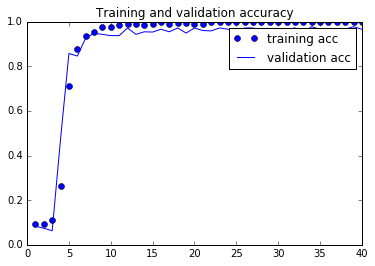

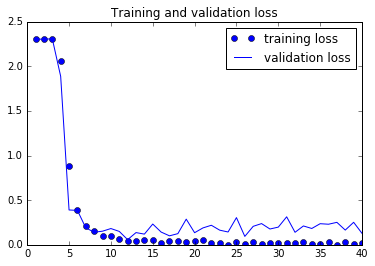

Maximum train accuracy : 1.0000
Maximum val accuracy : 0.9771


In [23]:
# Reusing the previous plotting function
plot_results(history)

print("Maximum train accuracy : %.4f" %max(history.history["acc"]))
print("Maximum val accuracy : %.4f" %max(history.history["val_acc"]))

Ok we did overfit the data, which is good.
<br>

Now we should find the perfect tradeoff between overfitting and underfitting. Let's add some dropout and try
regularizing the deeper model

In [44]:
# The model is similar to the one before except that dropout are added after each dense layers
deeper_model_regularized = models.Sequential()
deeper_model_regularized.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(100,100,1)))
deeper_model_regularized.add(layers.MaxPooling2D((2,2)))
deeper_model_regularized.add(layers.Conv2D(64,(3,3), activation='relu'))
deeper_model_regularized.add(layers.MaxPooling2D((2,2)))
deeper_model_regularized.add(layers.Conv2D(128,(3,3), activation='relu'))
deeper_model_regularized.add(layers.MaxPooling2D((2,2)))
deeper_model_regularized.add(layers.Conv2D(256,(3,3), activation='relu'))
deeper_model_regularized.add(layers.MaxPooling2D((2,2)))
deeper_model_regularized.add(layers.Flatten())
deeper_model_regularized.add(layers.Dense(512, activation='relu'))
deeper_model_regularized.add(layers.Dropout(0.5))
deeper_model_regularized.add(layers.Dense(64, activation='relu'))
deeper_model_regularized.add(layers.Dropout(0.4))
deeper_model_regularized.add(layers.Dense(32, activation='relu'))
deeper_model_regularized.add(layers.Dropout(0.2))
deeper_model_regularized.add(layers.Dense(10, activation='softmax'))

# Same as before
deeper_model_regularized.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['acc'])

# Same number of parameters
deeper_model_regularized.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 8, 8, 256)         295168    
__________

In [45]:
# Number of steps per epoch for the train and the validation pass
nb_steps_per_epoch = int(n_train_images/32)
validation_steps = int(n_val_images/32)

# The number of epochs is now 50
epochs = 50

# We will now use a callback to stop learning whenever the val accuracy doesn't increase anymore
Early_stopping = keras.callbacks.EarlyStopping(monitor = "val_acc", patience = 10, mode="max")

# Main learning loop
history = deeper_model_regularized.fit_generator(train_generator,
                              steps_per_epoch = nb_steps_per_epoch,
                              epochs = epochs,
                              validation_data = validation_generator,
                              validation_steps = validation_steps,
                              callbacks = [Early_stopping]) 

Epoch 1/50
57/57 [==============================] - 5s 93ms/step - loss: 2.3043 - acc: 0.1026 - val_loss: 2.3034 - val_acc: 0.0990
Epoch 2/50
57/57 [==============================] - 5s 82ms/step - loss: 2.3030 - acc: 0.1053 - val_loss: 2.3063 - val_acc: 0.0857
Epoch 3/50
57/57 [==============================] - 5s 79ms/step - loss: 2.3033 - acc: 0.0948 - val_loss: 2.3048 - val_acc: 0.1029
Epoch 4/50
57/57 [==============================] - 5s 83ms/step - loss: 2.3026 - acc: 0.0998 - val_loss: 2.3039 - val_acc: 0.1200
Epoch 5/50
57/57 [==============================] - 5s 84ms/step - loss: 2.2976 - acc: 0.1130 - val_loss: 2.2381 - val_acc: 0.1257
Epoch 6/50
57/57 [==============================] - 5s 82ms/step - loss: 2.0857 - acc: 0.2150 - val_loss: 1.9516 - val_acc: 0.2400
Epoch 7/50
57/57 [==============================] - 4s 75ms/step - loss: 1.8327 - acc: 0.3127 - val_loss: 1.5958 - val_acc: 0.3714
Epoch 8/50
57/57 [==============================] - 4s 78ms/step - loss: 1.4219 - a

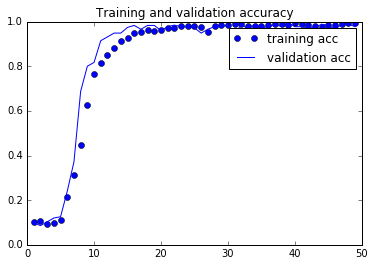

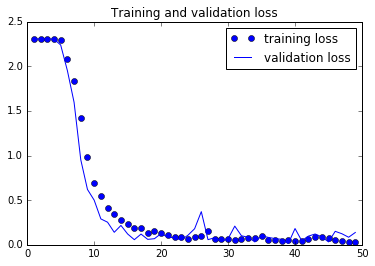

Maximum train accuracy : 0.9934
Maximum val accuracy : 0.9943


In [46]:
plot_results(history)

print("Maximum train accuracy : %.4f" %max(history.history["acc"]))
print("Maximum val accuracy : %.4f" %max(history.history["val_acc"]))

Yay ! We clearly see an improvement ! 